# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

### Reviewer:

In general, I try to collect import statements that were scattered throughout the file into one block near the top of the file.  Note that importing `sklearn.cross_validation import train_test_split` triggers a `DeprecationWarning`.  This is benign, but in future versions I would follow the instructions to switch to the recommended `model_selection` module

In [2]:
# Import modules

from collections import deque
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
import math
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pdb
import pickle
import tensorflow as tf

/home/dventimi/anaconda3/envs/CarND-Traffic-Signs/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Reviewer:
Like with the module imports, I tend to like to gather parameters and hyper-parameters into one contiguous block near the beginning of the file.  

In [3]:
# Set parameters

ACCURACY_THRESHOLD = 0.01
BATCH_SIZE = 100
LEARNING_RATE = 0.001
MAX_EPOCHS = 100
MIN_EPOCHS = 10
MU = 0
SIGMA = 0.1
VALIDATION_FRACTION = 0.2

### Reviewer:
Per the instructions, I load the training and test data from the parent directory, which is where I downloaded it.

In [4]:
# Load traffic sign data

training_file = '../train.p'
testing_file = '../test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_tests, y_tests = test['features'], test['labels']
n_train = train['features'].shape[0]
n_test = test['features'].shape[0]
image_shape = X_train.shape[1:]
n_classes = len(np.unique(train['labels']))

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [5]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples

n_train = train['labels'].shape[0]

# TODO: Number of testing examples.

n_test = test['labels'].shape[0]

# TODO: What's the shape of an traffic sign image?

image_shape = train['features'].shape[1:]

# TODO: How many unique classes/labels there are in the dataset.

n_classes = len(np.unique(train['labels']))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

### Reviewer:
Next, I plot a gallery of randomly-chosen images from the training set, just to get a sense of what I'm dealing with.

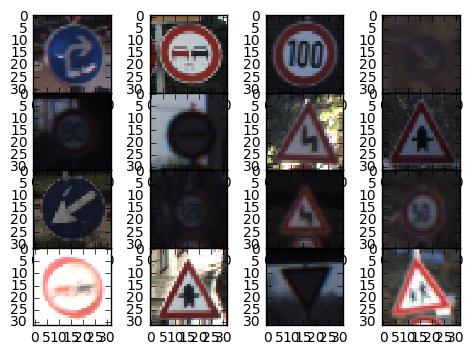

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.

# Explore the data

# Sample of n sign images
plt.ion()
n = 16
columns = 4
rows = n // columns + int(n % columns > 0)
fig = plt.figure()
plt.subplots_adjust(wspace=0.001, hspace=0.001)
for t in zip(range(n), np.random.choice(np.array(range(n_train)), n, False)):
    fig.add_subplot(rows,columns,t[0]+1)
    plt.imshow(train['features'][t[1],], interpolation='nearest')

### Reviewer:
Next, I plot a histogram of the classes in the training set.  As you can see, some classes are much more heavily represented than others.  This *might* pose a problem for training the model, but the issue is far from obvious, as discussed below.

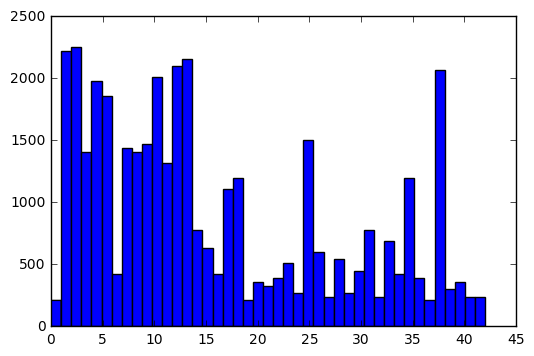

In [7]:
fig = plt.figure()
h = plt.hist(train['labels'], n_classes)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Reviewer:
Next, I process the data.  Really, this just involves first shuffling the training data, then second scaling (or "conditioning") the data.  Shuffling is important for the training data for several related reasons.  First, I'm applying "mini-batching" in order to stay within memory constraints of the machine.  That implies a form of "stochastic gradient descent" (even if we're not actually using a simple gradient descent optimizer), in which small learning steps are taken in the face of randomly-selected data.  Important in this process is that each batch be a random sample of the whole training set.  However, the training set that we're given has structure:  sequences of training examples for the same label are contiguous within the training set, and so small batches typically will contain only one or two labels.  That would comprise a heavily-biased sample rather than a random sample.  Hence, the entire training set is randomized at the start.  Note that this isn't strictly necessary for the test set, since obviously the test set isn't used to train the model.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Shuffle the training data

train['features'], train['labels'] = shuffle(X_train, y_train)

# Scale images

train['features'] = (train['features']-128.)/128.
test['features'] = (test['features']-128.)/128.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

### Reviewer:
**Answer:**  As discussed above, the training set is shuffled so that the batches in a mini-batching setup will comprise random samples of the training set, as opposed to biased samples of the training set.  Moreover, the the data are scaled so that the pixel values have a mean of approximately 0, and occupy the interval [-1, 1].  This conditions the data and tends to give more reliable models, as discussed in the lectures.

I also want to address the very uneven distribution of classes among the training set.  As you can see from the histogram above, some classes are much more heavily represented than others are.  A comment in the problem setup above hints at the possibility varying numbers of examples per label (the third bullet point).  Consequently, I briefly considered further preprocessing the data to obtain a more uniform distribution.  However, I thought better of it, for these reasons.

* I could remove examples from overly-represented classes, but that amounts to throwing away data, which isn't good.
* I could pad the training set by inserting copies of randomly-selected under-represented classes.  Essentially, the model would "see" certain examples more than once.  But, that has problems, too.
* Ultimately, any such exercise represents me *a priori* biasing the model toward certain outcomes.  To be precise, it biases toward an equal likelihood for any of the 43 different road signs.
* However, I know nothing about German road signs.
* I could plot a similar histogram for the classes in the test set, but I want to avoid looking at it as much as is possible.
* Moreover, suppose the test set also is not uniform.  Is its non-uniformity exactly the same as the non-uniformity of the training set?  How would I determine one way or the other?
* Alternatively, If I assume the training set and test set were randomly (and fairly) sampled from actual road signs as they appear in Germany, then there's reason to believe the training set and test set should roughly have the same distribution.
* In other words, some signs may be more common than others.  Put that way, this is almost certainly true.
* But then in that case, how we tune the model depends on what we want to achieve.  If we want to obtain the best *aggregate* performance, across a large sample of signs *as they actually appear on the road* then we should want higher accuracy for more common signs and should tolerate lower accuracy for less-common signs (*modulo* especially-important albeit rare signs, like safety warnings).
* There are deep statistical questions lurking down this path, and hence it could be a very, very long path.
* Consequently, for this exercise I saw no good reason for abusing the training set into any fore-ordained shape.

In [7]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Reserve a portion of training data as validation data

X_train, X_valid, y_train, y_valid = train_test_split(train['features'], train['labels'], test_size=VALIDATION_FRACTION, random_state=42)
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_tests = X_tests.shape[0]

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

### Reviewer:
**Answer:**  I use the Scikit-Learn `train_test_split` function (deprecated) to save off a portion of the training set in order to form a new validation set.  The fraction that is reserved for validation is variable, set by the `VALIDATION_FRACTION` parameter, which is set to `0.1` above, or 10%.

In [8]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# Define architecture

def SignNet(x, keep_prob, n_classes):    
    # Layer 1: Convolutional. Input = 32x32xinput_channels. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, x.get_shape()[3].value, 6), mean = MU, stddev = SIGMA), name='conv1_W')
    conv1_b = tf.Variable(tf.zeros(6), name='conv1_b')
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation.
    conv1 = tf.nn.relu(conv1)
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = MU, stddev = SIGMA), name='conv2_W')
    conv2_b = tf.Variable(tf.zeros(16), name='conv2_b')
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # Activation.
    conv2 = tf.nn.relu(conv2)
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = MU, stddev = SIGMA), name='fc1_W')
    fc1_b = tf.Variable(tf.zeros(120), name='fc1_b')
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation.
    fc1    = tf.nn.relu(fc1)
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = MU, stddev = SIGMA), name='fc2_W')
    fc2_b  = tf.Variable(tf.zeros(84), name='fc2_b')
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    # Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout
    fc2_drop = tf.nn.dropout(fc2, keep_prob)
    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = MU, stddev = SIGMA), name='fc3_W')
    fc3_b  = tf.Variable(tf.zeros(n_classes), name='fc3_b')
    logits = tf.matmul(fc2_drop, fc3_W) + fc3_b
    return logits

### SignNet Architectural Diagram

I generated a visualization of the TensorFlow graph for the SignNet architecture, using TensorBoard.  However, the output was quite busy and difficult to read and so I omitted it from this document.  It is included in the GitHub project that contains this document, in the "CarND-Traffic-Signs.png" file.  In lieu of that, I threw together a quick and dirty manual illustration of the architecture with a [ditaa](http://ditaa.sourceforge.net/) diagram, included inline here.

![SignNet Architecture](layers.png)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


### Reviewer:
**Answer:**  Honestly, the final architecture really is little more than a lightly-adapted version of the original LeNet architecture.  My strategy was to begin with that basic architecture, adapt it for the slightly different characteristics of this problem, and then evaluate it.  I anticipated needing to change the architecture, perhaps dramatically, in order to obtain satisfactory performance on the validation set.  However, with just a few small changes I achieved suprisingly good results, and therefore saw no need to embellish it further.

The main changes are these:

* I pass in `keep_prob` and `n_classes` parameters, discussed below.
* The first Convolutional Layer `Layer 1` originally hard-coded 1 input-channel.  Now, it's dynamic based on the shape of the input array.
* I added 1 dropout layer, between the first and second fully-connected layers.  A dropout layer provides a form of regularization.  Regularization adds robustness to a model and its presence should be seen in a model that can be trained to a higher accuracy before overtraining sets in.  In practice, my model trained pretty well and pretty quickly, so it's not clear even this one dropout layer was strictly necessary.  For that reason, I declined to add additional dropout layers.  This dropout layer uses a `keep_prob` parameter that's passed in.
* The second fully-connected layer (the "readout layer") originally had 10 nodes, for the 10 output classes in the MNIST data.  Our data has 43 classes, so I made the number of nodes dynamic based on the `n_classes` input parameter.

In [10]:
### Train your model here.
### Feel free to use as many code cells as needed.

# Define the model

tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None,) + X_train.shape[1:])
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)
logits = SignNet(x, keep_prob, n_classes)
probability_operation = tf.nn.softmax(logits)
prediction_operation = tf.argmax(probability_operation, 1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Define evaluation function

def evaluate(sess, X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Train the model, validate, and test

def train_model(X_train, y_train, BATCH_SIZE):
    accuracy_window = deque(np.zeros(5, dtype='f'), 5)
    accuracy_means = deque(np.zeros(2, dtype='f'), 2)
    num_examples = len(X_train)
    for i in range(MAX_EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
        valid_accuracy = evaluate(sess, X_valid, y_valid)
        train_accuracy = evaluate(sess, X_train, y_train)
        accuracy_window.append(valid_accuracy)
        mean_accuracy = np.mean(accuracy_window)
        accuracy_means.append(mean_accuracy)
        accuracy_delta = accuracy_means[1]-accuracy_means[0]
        print("{},{:.3f},{:.3f},{:.3f},{:.3f}".format((i+1), valid_accuracy, mean_accuracy, accuracy_delta, train_accuracy))
        if (abs(accuracy_delta)<ACCURACY_THRESHOLD and i>MIN_EPOCHS):
            break
        
saver = tf.train.Saver()
sess = tf.Session()
try:
    saver.restore(sess, "model.ckpt")
except:
    sess.run(tf.initialize_all_variables())
    train_model(X_train, y_train, BATCH_SIZE)
    save_path = saver.save(sess, "model.ckpt")
    print(save_path)

print("Test Accuracy = {:.3f}".format(evaluate(sess, X_tests, y_tests)))

1,0.777,0.155,0.155,0.781
2,0.909,0.337,0.182,0.920
3,0.945,0.526,0.189,0.950
4,0.959,0.718,0.192,0.969
5,0.968,0.911,0.194,0.976
6,0.967,0.950,0.038,0.977
7,0.975,0.963,0.013,0.986
8,0.972,0.968,0.005,0.982
9,0.978,0.972,0.004,0.989
10,0.979,0.974,0.002,0.991
11,0.983,0.977,0.003,0.994
12,0.983,0.979,0.002,0.993
model.ckpt
Test Accuracy = 0.916


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


### Reviewer:
**Answer:**  As you can see above, I trained the model almost exactly as it was done in the original MNIST example.  That is, it has these features.

* The model is built up in TensorFlow with the usual function composition.
* The result of the `SignNet` function above is a TensorFlow tensor that when fed data, computes *logits*.
* The *logits* in principle would be passed to the `tf.nn.softmax()` function in the pipeline leading to optimization.  However, TensorFlow provides the handy `tf.nn.softmax_cross_entropy_with_logits` operation.  Consequently, we can skip a few steps in computing the cross-entropy.
* We need a `training_operation` operation, to perform one adjustment of the weights within the model.
* We need a `correct_prediction` operation, to determine which predictions the model makes are correct, with respect to the target labels.
* We need a `accuracy_operaton` operation, to then aggregate a stastical estimate of the accuracy of the predictions over a given batch of data, in order to guide the repeated training and to support stopping criteria.
* We define `evaluate` and `train_model` helper functions.
* The `evaluate` function exists primarily to ease evaluating the model and obtaining its accuracy over a large set of data that may not satisfy the machine's memory constraints.  It iterates over mini-batches and accumulates an accuracy estimate.
* The `train_model` function uses the `evaluate` method to obtain accuracy estimates that guide the training process and support stopping criteria.  Moreover, it iterates over a set of "epochs".  All of this is governed by additional parameters.
* The `MIN_EPOCHS` and `MAX_EPOCHS` parameters (set to 10 and 100, currently) bound the number of epochs.  The system will train for at least `MIN_EPOCHS` epochs, but for no more than `MAX_EPOCHS` epochs.
* The additional stopping criteria is this.  In the `accuracy_window` and `accuracy_means` local variables, I keep track of a set of validation accuracy estimates obtained (parameterized, but currently set to hold 5 values).  It's held in a ring buffer so that as new values are pushed onto the front, the oldest values are removed from the back, and it always maintains its fixed number of values.  The mean is taken across these values, and then is pushed onto a second ring buffer, with just 2 slots.  The difference between the values in those two slots then gives a crude estimate of the derivative (or slope) of a moving average of the accuracy estimates obtained over the validation set.  The magnitude (absolute value) of this derivative is then thresholded by a parameter.  Currently, that parameter is set to `0.01` and when it falls within that, training stops.  My reasoning is this.  In principle, we want to stop training when performance on the validation set no longer improves.  We *could* wait until its slope becomes negative.  However, these are only estimates (of the moving average, of its derivative, etc.), and so it's not obvious that a small negative slope should be distinguished from a small positive slope.  Hence, when the slop of the validation accuracy falls within a small "window" about 0 (i.e., the validation accuracy changes by less than 1%, plus or minus), training stops.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

### Reviewer:
**Answer:**  Originally, I wanted to avoid the LeNet architecture and build up a solution *de novo* (from scratch).  However, that proved difficult because the TensorFlow programming model is somewhat finicky and is unforgiving of beginners.  I ran into lots of problems that had nothing to do with training neural nets.  Consequently, I relented and settled for starting with the LeNet architecture developed for the MNIST data.  As discussed above, I adapted it in just a few small ways so that it would work with the Traffic Sign data.

In hindsight, that seems a very sensible approach.  After all, the Traffic Sign data are 32 x 32 pixel images, and the original LeNet architecture was set up for 32 x 32 pixel images; in fact, it had to be adapted for the MNIST data by padding the image arrays.  The only real difference between the traffic sign data and the MNIST data, aside from their shape, is 1) the traffic sign data are RGB color images, whereas the MNIST data are grayscale, and 2) the traffic sign data have 43 classes rather than MNIST's 10.  Adaptations to remove the padding, to cope with the color images, and to support the larger number of classes were easy to make, as discussed above.

My strategy then was to iteratively embellish the LeNet architecture with additional layers until satisfactory performance on the validation set was achieved.  In practice, I got as far as adding a dropout layer (as discussed above) before arriving at performance that was sufficient.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



### Reviewer:
**Answer:**  As you can see by the image gallery below, I ended up using more than just five candidate images.  I found a few "German traffic signs" on the internet, and then augmented that with quite a few additional photos that I took myself with a mobile phone camera.  In total, I ended up with 12 images.  With respect to these images, there are several observations that I'd like to make.

* Though I found a couple of "German traffic signs" on the internet, I didn't make a great effort to ensure they are among the examples within the training set.  Perhaps that set is not completely representative of all German traffic signs.
* All of the rest are pictures taken locally, in California, in The United States.
* The model was trained (and validated, and tested) exclusively with German traffic sign data.
* Given that I don't live in Germany, most of my candidate images are not German traffic signs.
* Therefore, there's no particular reason to expect that the model should be able to identify most of the new images I presented to it.  In fact, it seems like we should expect that it gets most of them "wrong."
* At best, it would classify American traffic signs accordingly as they resemble German traffic signs in only the grossest ways.
* Notice that I also challenged the model with a few images that are not even traffic signs at all.  There is an image of an automobile spare tire (row 2, col 2) and a realtor sign (row 2, col 3).  
* These two images aren't even traffic signs, but there's no particular reason the model would know that. 
* The image captions in the gallery give the name (from `signnames.csv`) for the model's classification of that sign.  As you can see, they're all essentially "wrong."
* In fact, only the three German signs ((row 1, col2), (row 3, col 2), (row 4, col 3)) potentially could be in some sense classified "right."
* Of those three German signs, it seems to get the second one (row 3, col 2) right.
* I suppose I could fish around on the internet for more German signs, but seriously, this has gone on long enough.
* As far as what features help classification, and what features make it difficult, I expect that only the most basic of features, like color, geometric shape, and coarse details, factor into any classification.
* Given the low resolution of the image, it's certain that lettering in medium and small fonts plays essentially no role in classification.

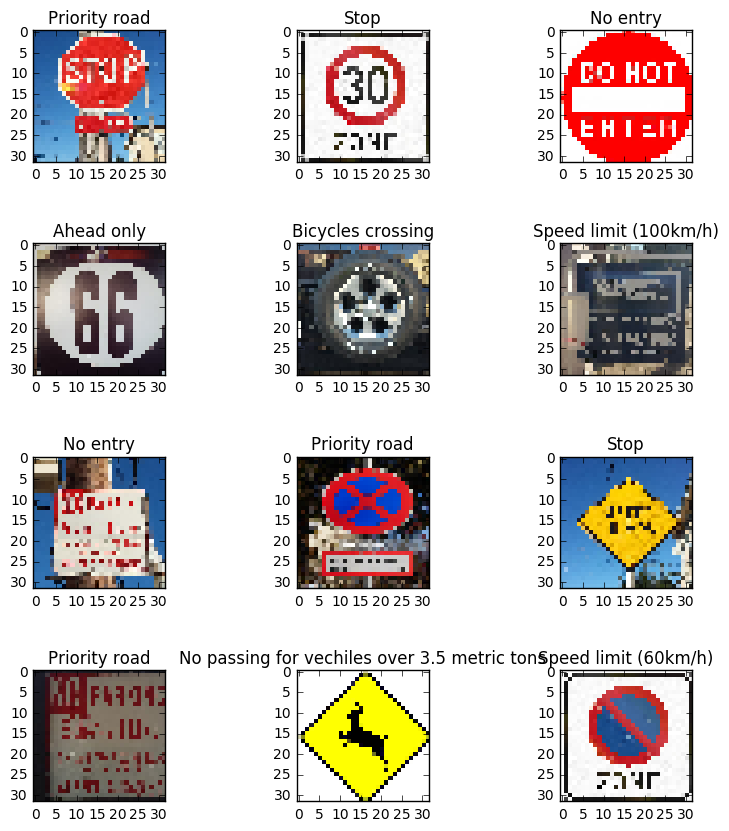

In [11]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

# Test a Model on New Images

image_loader = \
        tf.image.resize_images(
            tf.image.decode_jpeg(
                tf.WholeFileReader().read(
                    tf.train.string_input_producer(
                        tf.train.match_filenames_once("./images/*.jpg")))[1]),
            [32, 32], method=1)

with tf.Session() as loader_sess:
    tf.initialize_all_variables().run()
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    images = np.array([
        loader_sess.run(image_loader),
        loader_sess.run(image_loader),
        loader_sess.run(image_loader),
        loader_sess.run(image_loader),
        loader_sess.run(image_loader),
        loader_sess.run(image_loader),
        loader_sess.run(image_loader),
        loader_sess.run(image_loader),
        loader_sess.run(image_loader),
        loader_sess.run(image_loader),
        loader_sess.run(image_loader),
        loader_sess.run(image_loader)])
    coord.request_stop()
    coord.join(threads)

classifications = sess.run(prediction_operation, feed_dict={x:images, keep_prob:1.0})

with open('signnames.csv') as f:
    lines = f.read().splitlines()
splitlines = [line.split(',') for line in lines[1:]]
signnames = {line[0]:line[1] for line in splitlines}

plt.ion()
n = 12
columns = 3
rows = n // columns + int(n % columns > 0)
fig = plt.figure(figsize=(8.5, 11))
plt.subplots_adjust(wspace=1, hspace=0.001)
for t in zip(range(n), images, classifications):
    ax = fig.add_subplot(rows,columns,t[0]+1)
    ax.set_title(signnames[str(t[2])])
    plt.imshow(t[1], interpolation='nearest')

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


### Reviewer:
**Answer:**  Of the three German signs provided, it got 1 of them right.  These are really low number statistics, but crudely, that's about "33% right."  Obviously, there's no "right" or "wrong" for the American signs.

From the prediction I did to the candidate GERMAN sign images, the testing accuracy is (crudely) about 33%, however, the model prediction accuracy on the training set was about 92%. As a result, I believe my model did not perform well in the real world situation. The possible reasons would be these.

1. The brightness of the image may be different from the brightness of image in the training set.
2. The contrast of the image may be different from the contrast of images in the training set.
3. The the angle of the image may be different from the angles of images in the training set.
4. The image may be blurred.
5. The training set may not contain these particular German signs, if the training set is not complete.

**NOTE:**  When I say that the accuracy on the candidate GERMAN sign images is (crudely) about 33%, it's crucial to understand that this comes from evaluating its performance *only* on *German* sign images taken from the Internet.  Those are a subset of all of the "found images" classified by the net, the rest being images I took with my camera.  Images I took with my camera *play no role in this accuracy estimate* and this is for a deliberate, important reason.  As discussed above, the images I took with my camera are in California.  They are not "German traffic signs" in any way, shape, or form.  Consequently, it is *not possible for the model to classify these images correctly if the model has only been trained on German sign images!*  After ally, the model can only classify images according to the 43 classes emitted by the read-out layer, which correspond to the 43 classes it's been trained on.  California road signs are *separate classes*.  They're not *in* this set of 43 classes.  Therefore, there can be no "right or wrong answer" for these signs (or, another way to think of it is that for the California signs, they're *always* wrong answers).  I'm very reluctant to concede this point.

In [14]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

# Visualize uncertainty

X_check, y_check = train['features'][:1000,], train['labels'][:1000,]

def count_in_top_n(sess, X_check, y_check, k=5):
    probability_operation = tf.nn.softmax(logits)
    prediction_operation = tf.argmax(probability_operation, 1)
    correct = sess.run(correct_prediction, feed_dict={x: X_check, y: y_check, keep_prob:1.0})
    probs = sess.run(probability_operation, feed_dict={x: X_check, y: y_check, keep_prob:1.0})
    predictions = sess.run(tf.argmax(probs, 1), feed_dict={x: X_check, y: y_check, keep_prob:1.0})
    topn = sess.run(tf.nn.top_k(probs, k=k), feed_dict={x: X_check, y: y_check, keep_prob:1.0})
    return sum([len(np.where(p[1]==p[0])[0])>0 for p in zip(y_check[~correct], topn[1][~correct])]), sum(~correct)

print(count_in_top_n(sess, X_check, y_check, 1))
print(count_in_top_n(sess, X_check, y_check, 2))
print(count_in_top_n(sess, X_check, y_check, 3))
print(count_in_top_n(sess, X_check, y_check, 4))
print(count_in_top_n(sess, X_check, y_check, 5))

(0, 6)
(6, 6)
(6, 6)
(6, 6)
(6, 6)


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

### Reviewer:
**Answer:**  Here's what I did in the analysis above.

* Took a batch of 1000 of the test images (if you insist, I'll do it for all the test images).
* Used the model to compute the probability associated with each class.
* Used the probabilities and the `tf.nn.argmax` operation in the usual way to compute the predicted class.
* Computed a boolean array `correct` of which among the predictions are correct, with respect to the given labels.
* Used `tf.nn.top_k` against the computed probabilities to compute the top *k* probabilities, and their indices, for each example in the batch (*k* can vary between 1 and 5).
* By negating the `correct` Boolean array (`~correct`), indexed into the actual target labels and into the corresponding `topn` indices, counting up the number of times the correct label appears within the top *k* predicted labels (it should occur 0 or 1 times).
* I then sum the number of times that's greater than 1, across the whole batch.  In other words, I'm counting the number of times across the *incorrect* predictions in the batch (of 1000) that the correct lable was within the top *k* predicted labels.
* All of this happens in the `count_in_top_n` function shown above.
* In this particular run, for this particular batch of 1000 test examples, the model got 6 wrong.
* For those six, I use `count_in_top_n`, as described above, to check how many times the correct label was within the top *k* predicted labels, for k in [1, 2, 3, 4, 5].  
* It may not be obvious (you may have to re-read the above), but when *k* = 1, that's exactly the original classification case.  So when *k* = 1, `count_in_top_n` should give 0 (because, for this 6, it got all of them wrong).
* It does give 0.  That's good.
* For the second case when *k* = 2, `count_in_top_n` gives 6.  That's also good.
* In other words, for this batch of 1000 test examples, where the model got 6 wrong, in all 6 cases the correct answer was the *next most likely class predicted by the model.*
* Obviously, for all other *k* in [3, 4, 5, 6], `count_in_top_n` will also give 6, since it gave 6 in the case that *k* = 2.

I know this may be hard to understand, so please re-read it if necessary.  The upshot is that, it seems as if when the model is wrong, it's not "far off."  Typically, the "correct" class is the next most likely class as predicted by the model.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.